In [1]:
import sys
import os
sys.path.append(os.path.abspath("../src/"))
import extract.data_loading as data_loading
import extract.compute_predictions as compute_predictions
import extract.compute_shap as compute_shap
import extract.compute_ism as compute_ism
import model.util as model_util
import model.profile_models as profile_models
import model.train_profile_model as train_profile_model
import matplotlib.font_manager as font_manager
import plot.viz_sequence as viz_sequence
import torch
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import json
import tqdm
tqdm.tqdm_notebook()  # It is necessary to call this before the tqdm.notebook submodule is available

/users/amtseng/miniconda3/envs/att-priors/lib/python3.7/site-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


|<bar/>| 0/? [00:00<?, ?it/s]

In [2]:
# Plotting defaults
font_manager.fontManager.ttflist.extend(
    font_manager.createFontList(
        font_manager.findSystemFonts(fontpaths="/users/amtseng/modules/fonts")
    )
)
plot_params = {
    "figure.titlesize": 22,
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "legend.fontsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "font.family": "Roboto",
    "font.weight": "bold"
}
plt.rcParams.update(plot_params)

### Define paths for the model and data of interest

In [3]:
# Shared paths/constants
reference_fasta = "/users/amtseng/genomes/hg38.fasta"
chrom_sizes = "/users/amtseng/genomes/hg38.canon.chrom.sizes"
data_base_path = "/users/amtseng/att_priors/data/processed/"
model_base_path = "/users/amtseng/att_priors/models/trained_models/profile/"
chrom_set = ["chr1"]
input_length = 1346
profile_length = 1000
fourier_att_prior_freq_limit = 200
fourier_att_prior_freq_limit_softness = 0.2
att_prior_grad_smooth_sigma = 3

In [ ]:
# SPI1
condition_name = "SPI1"
files_spec_path = os.path.join(data_base_path, "ENCODE_TFChIP/profile/config/SPI1/SPI1_training_paths.json")
num_tasks = 4
num_strands = 2
controls = "matched"
task_index = None
model_class = profile_models.ProfilePredictorWithMatchedControls
noprior_model_path = os.path.join(model_base_path, "SPI1/27/model_ckpt_epoch_17.pt")
prior_model_path = os.path.join(model_base_path, "SPI1_prior/14/model_ckpt_epoch_18.pt")

In [ ]:
# GATA2
condition_name = "GATA2"
files_spec_path = os.path.join(data_base_path, "ENCODE_TFChIP/profile/config/GATA2/GATA2_training_paths.json")
num_tasks = 3
num_strands = 2
controls = "matched"
task_index = None
model_class = profile_models.ProfilePredictorWithMatchedControls
noprior_model_path = os.path.join(model_base_path, "GATA2/6/model_ckpt_epoch_18.pt")
prior_model_path = os.path.join(model_base_path, "GATA2_prior/12/model_ckpt_epoch_19.pt")

In [ ]:
# K562
condition_name = "K562"
files_spec_path = os.path.join(data_base_path, "ENCODE_DNase/profile/config/K562/K562_training_paths.json")
num_tasks = 1
num_strands = 1
controls = "shared"
task_index = None
model_class = profile_models.ProfilePredictorWithSharedControls
noprior_model_path = os.path.join(model_base_path, "K562/19/model_ckpt_epoch_19.pt")
prior_model_path = os.path.join(model_base_path, "K562_prior/16/model_ckpt_epoch_20.pt")

In [4]:
# BPNet
condition_name = "BPNet"
reference_fasta = "/users/amtseng/genomes/mm10.fasta"
chrom_sizes = "/users/amtseng/genomes/mm10.canon.chrom.sizes"
files_spec_path = os.path.join(data_base_path, "BPNet_ChIPseq/profile/config/BPNet_training_paths.json")
num_tasks = 3
num_strands = 2
controls = "shared"
task_index = None
model_class = profile_models.ProfilePredictorWithSharedControls
noprior_model_path = os.path.join(model_base_path, "BPNet/20/model_ckpt_epoch_18.pt")
prior_model_path = os.path.join(model_base_path, "BPNet_prior/25/model_ckpt_epoch_17.pt")

### Import models

In [5]:
torch.set_grad_enabled(True)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
def restore_model(model_path):
    model = model_util.restore_model(model_class, model_path)
    model.eval()
    model = model.to(device)
    return model

In [6]:
# Import the model without priors
noprior_model = restore_model(noprior_model_path)

In [7]:
# Import the model with priors
prior_model = restore_model(prior_model_path)

### Data preparation
Create an input data loader, that maps coordinates to data needed for the model

In [8]:
input_func = data_loading.get_profile_input_func(
    files_spec_path, input_length, profile_length, reference_fasta
)
pos_coords = data_loading.get_positive_profile_coords(
    files_spec_path, chrom_set=chrom_set, task_ind=task_index
)

### SHAP explainers
Create DeepSHAP explainers

In [9]:
noprior_shap_explainer = compute_shap.create_profile_explainer(
    noprior_model, input_length, profile_length, num_tasks, num_strands, controls,
    task_index=task_index
)

In [10]:
prior_shap_explainer = compute_shap.create_profile_explainer(
    prior_model, input_length, profile_length, num_tasks, num_strands, controls,
    task_index=task_index
)

### Compute loss values over test set

In [11]:
# Sample a subset of peaks randomly to compute predictions for
num_samples = 1000
rng = np.random.RandomState(20200318)
sample_coords = pos_coords[np.random.choice(len(pos_coords), size=num_samples, replace=False)]

In [12]:
# Add a random jitter to avoid center-bias
jitters = np.random.randint(-128, 128 + 1, size=len(sample_coords))
sample_coords[:, 1] = sample_coords[:, 1] + jitters
sample_coords[:, 2] = sample_coords[:, 2] + jitters

In [13]:
noprior_preds = compute_predictions.get_profile_model_predictions(                                              
    noprior_model, sample_coords, num_tasks, input_func, controls=controls,                        
    fourier_att_prior_freq_limit=fourier_att_prior_freq_limit,
    fourier_att_prior_freq_limit_softness=fourier_att_prior_freq_limit_softness,
    att_prior_grad_smooth_sigma=att_prior_grad_smooth_sigma,
    return_losses=True, return_gradients=True, show_progress=True                                         
)

100%|██████████| 8/8 [00:09<00:00,  1.14s/it]


In [14]:
prior_preds = compute_predictions.get_profile_model_predictions(                                              
    prior_model, sample_coords, num_tasks, input_func, controls=controls,                        
    fourier_att_prior_freq_limit=fourier_att_prior_freq_limit,
    fourier_att_prior_freq_limit_softness=fourier_att_prior_freq_limit_softness,
    att_prior_grad_smooth_sigma=att_prior_grad_smooth_sigma,
    return_losses=True, return_gradients=True, show_progress=True                                         
)

100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


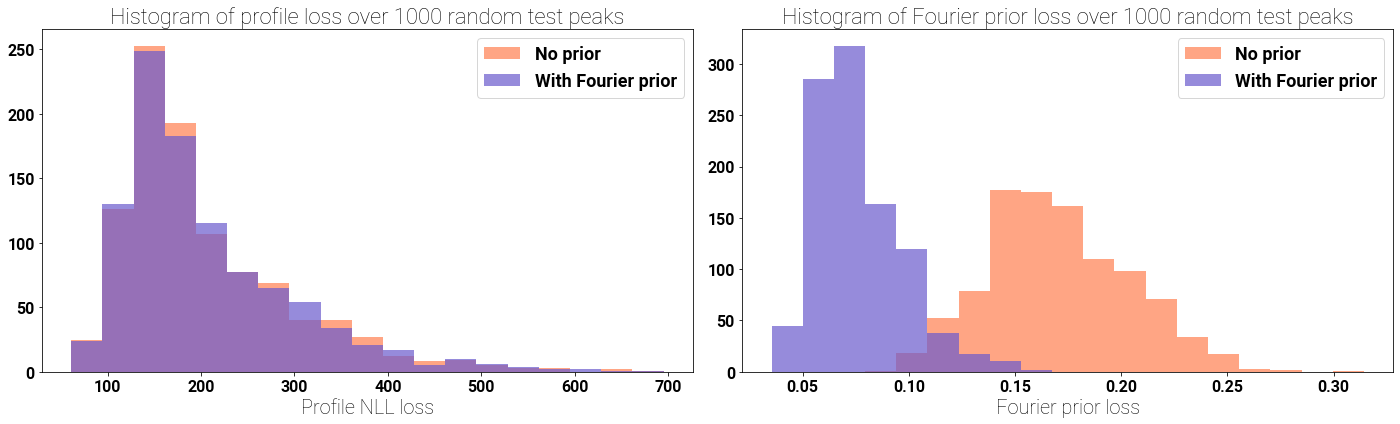

In [15]:
# Plot histogram of profile loss and prior loss over these conditions
bin_num = 20
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
all_vals = np.concatenate([noprior_preds["prof_losses"], prior_preds["prof_losses"]])
bins = np.linspace(np.min(all_vals), np.max(all_vals), bin_num)
ax[0].hist(noprior_preds["prof_losses"], bins=bins, color="coral", label="No prior", alpha=0.7)
ax[0].hist(prior_preds["prof_losses"], bins=bins, color="slateblue", label="With Fourier prior", alpha=0.7)
ax[0].set_title("Histogram of profile loss over %d random test peaks" % num_samples)
ax[0].set_xlabel("Profile NLL loss")
ax[0].legend()
all_vals = np.concatenate([noprior_preds["att_losses"], prior_preds["att_losses"]])
bins = np.linspace(np.min(all_vals), np.max(all_vals), bin_num)
ax[1].hist(noprior_preds["att_losses"], bins=bins, color="coral", label="No prior", alpha=0.7)
ax[1].hist(prior_preds["att_losses"], bins=bins, color="slateblue", label="With Fourier prior", alpha=0.7)
ax[1].set_title("Histogram of Fourier prior loss over %d random test peaks" % num_samples)
ax[1].set_xlabel("Fourier prior loss")
ax[1].legend()
plt.tight_layout()

### Distribution of gradients and SHAP scores

In [16]:
def compute_shap_scores(model, sample, batch_size=128):
    """
    Given an array of N coordinates or bins, computes the SHAP scores
    for the model, returning an N x I x 4 array of SHAP scores and an
    N x I x 4 array of one-hot encoded sequence.
    """
    num_samples = len(sample)
    num_batches = int(np.ceil(num_samples / batch_size))
    
    all_shap_scores = np.empty((num_samples, input_length, 4))
    all_one_hot_seqs = np.empty((num_samples, input_length, 4))
        
    shap_explainer = compute_shap.create_profile_explainer(
        model, input_length, profile_length, num_tasks, num_strands, controls,
        task_index=task_index
    )

    for i in tqdm.notebook.trange(num_batches):
        batch_slice = slice(i * batch_size, (i + 1) * batch_size)
        batch = sample[batch_slice]

        input_seqs, profiles = input_func(batch)
        shap_scores = shap_explainer(
            input_seqs, cont_profs=profiles[:, num_tasks:], hide_shap_output=True
        )
        all_shap_scores[batch_slice] = shap_scores
        all_one_hot_seqs[batch_slice] = input_seqs
    return all_shap_scores, all_one_hot_seqs

In [17]:
noprior_grads = noprior_preds["input_grads"]
prior_grads = prior_preds["input_grads"]

In [18]:
noprior_shap, _ = compute_shap_scores(noprior_model, sample_coords)
prior_shap, one_hot_seqs = compute_shap_scores(prior_model, sample_coords)
assert np.all(one_hot_seqs == noprior_preds["input_seqs"])

In [19]:
def dft(signal):
    fourier_coeffs = np.fft.fft(signal)
    fourier_freqs = 2 * np.pi * np.fft.fftfreq(signal.size)
    fourier_freqs = fourier_freqs[:int(len(fourier_freqs) / 2)]  # Only the positive frequencies
    mags = np.abs(fourier_coeffs)[:int(len(fourier_coeffs) / 2)]  # Frequency magnitudes are symmetric
    return fourier_freqs, mags

In [20]:
def fourier_highfreq_mags(imp_scores, freq_limit):
    """
    For an N x I x 4 array of actual importance scores, computes the sum of the
    Fourier magnitudes in high frequencies, defined by `freq_limit`. Returns an
    N-array of Fourier scores (i.e. sum of low-frequency magnitudes)
    """
    scores = []
    # Normalize
    imp_scores_sum = np.sum(np.abs(imp_scores), axis=2)  # Make into N x I
    
    for score_track in imp_scores_sum:
        freqs, mags = dft(score_track)
        freqs, mags = freqs[1:], mags[1:]  # Cut off DC
        mags = mags / np.sum(mags)  # Normalize
        scores.append(np.sum(mags[freq_limit:]))
    return np.array(scores)

In [21]:
def entropy(imp_scores, pseudocount=0.001):
    """
    For an N x I x 4 array of actual importance scores, computes the entropy
    of each track. Returns an N-array of entropy values.
    """
    scores = []
    # Normalize
    imp_scores_sum = np.sum(np.abs(imp_scores), axis=2)  # Make into N x I
    imp_scores_sum = imp_scores_sum + pseudocount
    imp_scores_norm = imp_scores_sum / np.sum(imp_scores_sum, axis=1, keepdims=True)
    
    return -np.sum(imp_scores_norm * np.log2(imp_scores_norm), axis=1)

In [22]:
noprior_grad_fourier_scores = fourier_highfreq_mags(noprior_grads * one_hot_seqs, fourier_att_prior_freq_limit)
prior_grad_fourier_scores = fourier_highfreq_mags(prior_grads * one_hot_seqs, fourier_att_prior_freq_limit)
noprior_grad_entropy_scores = entropy(noprior_grads * one_hot_seqs)
prior_grad_entropy_scores = entropy(prior_grads * one_hot_seqs)

In [23]:
noprior_shap_fourier_scores = fourier_highfreq_mags(noprior_shap * one_hot_seqs, fourier_att_prior_freq_limit)
prior_shap_fourier_scores = fourier_highfreq_mags(prior_shap * one_hot_seqs, fourier_att_prior_freq_limit)
noprior_shap_entropy_scores = entropy(noprior_shap * one_hot_seqs)
prior_shap_entropy_scores = entropy(prior_shap * one_hot_seqs)

In [24]:
def plot_global_smoothness(
    noprior_imp_fourier_scores, prior_imp_fourier_scores, noprior_imp_entropy_scores,
    prior_imp_entropy_scores, imp_type
):
    bin_num = 20
    fig, ax = plt.subplots(1, 2, figsize=(20, 6))
    all_vals = np.concatenate([noprior_imp_fourier_scores, prior_imp_fourier_scores])
    bins = np.linspace(np.min(all_vals), np.max(all_vals), bin_num)
    ax[0].hist(noprior_imp_fourier_scores, bins=bins, color="coral", label="No prior", alpha=0.7)
    ax[0].hist(prior_imp_fourier_scores, bins=bins, color="slateblue", label="With Fourier prior", alpha=0.7)
    ax[0].set_xlabel("Sum of high-frequency Fourier magnitudes")
    all_vals = np.concatenate([noprior_imp_entropy_scores, prior_imp_entropy_scores])
    bins = np.linspace(np.min(all_vals), np.max(all_vals), bin_num)
    ax[1].hist(noprior_imp_entropy_scores, bins=bins, color="coral", label="No prior", alpha=0.7)
    ax[1].hist(prior_imp_entropy_scores, bins=bins, color="slateblue", label="With Fourier prior", alpha=0.7)
    ax[1].set_xlabel("Entropy")
    ax[1].legend()
    title = "Histograms of smoothness of %s" % imp_type
    title += "\n%s profile models" % condition_name
    title += "\nComputed on %d randomly drawn test peaks" % num_samples
    fig.suptitle(title)
    plt.subplots_adjust(top=0.80)
    plt.show()
    
    def draw_xy_line(ax):
        limits = [
        np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()]),
        ]
        ax.plot(limits, limits, "--", alpha=0.5, color="black")
        ax.set_aspect("equal")
        ax.set_xlim(limits)
        ax.set_ylim(limits)
    fig, ax = plt.subplots(1, 2, figsize=(20, 6))
    ax[0].scatter(noprior_imp_fourier_scores, prior_imp_fourier_scores, color="mediumorchid")
    ax[0].set_xlabel("High frequency sum without prior")
    ax[0].set_ylabel("High frequency sum with Fourier prior")
    ax[1].scatter(noprior_imp_entropy_scores, prior_imp_entropy_scores, color="mediumorchid")
    ax[1].set_xlabel("Entropy without prior")
    ax[1].set_ylabel("Entropy with Fourier prior")
    draw_xy_line(ax[0])
    draw_xy_line(ax[1])
    title = "Pairwise comparison of %s smoothness" % imp_type
    title += "\n%s profile models" % condition_name
    title += "\nComputed on %d randomly drawn test peaks" % num_samples
    fig.suptitle(title)
    plt.subplots_adjust(top=0.80)
    plt.show()
    
    print("High-frequency Fourier sum:")
    print("Average without priors: %f" % np.nanmean(noprior_imp_fourier_scores))
    print("Average with priors: %f" % np.nanmean(prior_imp_fourier_scores))
    w, p = scipy.stats.wilcoxon(noprior_imp_fourier_scores, prior_imp_fourier_scores, alternative="greater")
    print("One-sided Wilcoxon test: w = %f, p = %f" % (w, p))
    print("Entropy:")
    print("Average without priors: %f" % np.nanmean(noprior_imp_entropy_scores))
    print("Average with priors: %f" % np.nanmean(prior_imp_entropy_scores))
    w, p = scipy.stats.wilcoxon(noprior_imp_entropy_scores, prior_imp_entropy_scores, alternative="greater")
    print("One-sided Wilcoxon test: w = %f, p = %f" % (w, p))

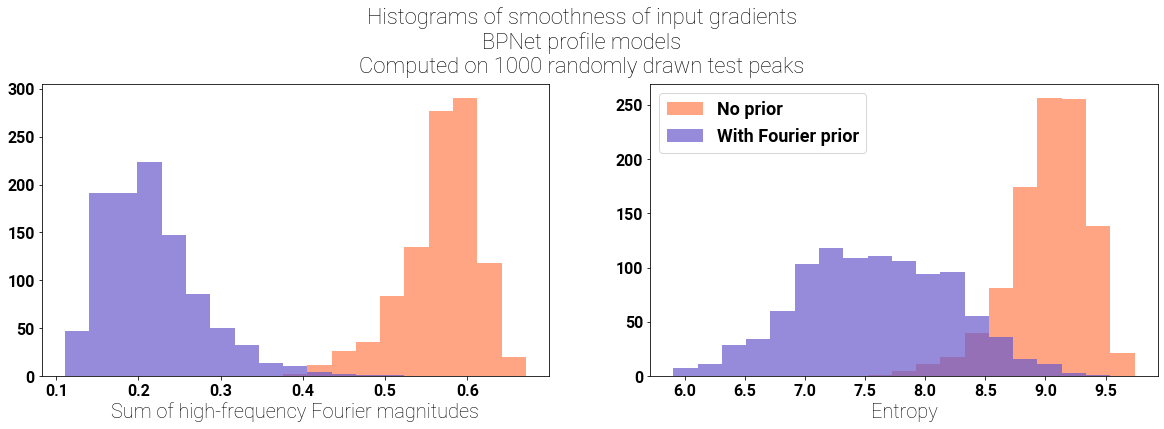

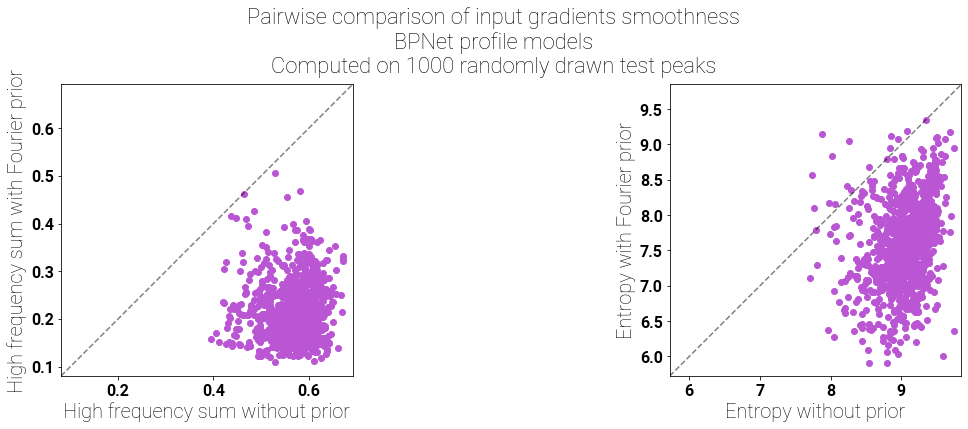

High-frequency Fourier sum:
Average without priors: 0.568112
Average with priors: 0.215500
One-sided Wilcoxon test: w = 500500.000000, p = 0.000000
Entropy:
Average without priors: 9.030279
Average with priors: 7.586850
One-sided Wilcoxon test: w = 499539.000000, p = 0.000000


In [25]:
plot_global_smoothness(
    noprior_grad_fourier_scores, prior_grad_fourier_scores, noprior_grad_entropy_scores,
    prior_grad_entropy_scores, "input gradients"
)

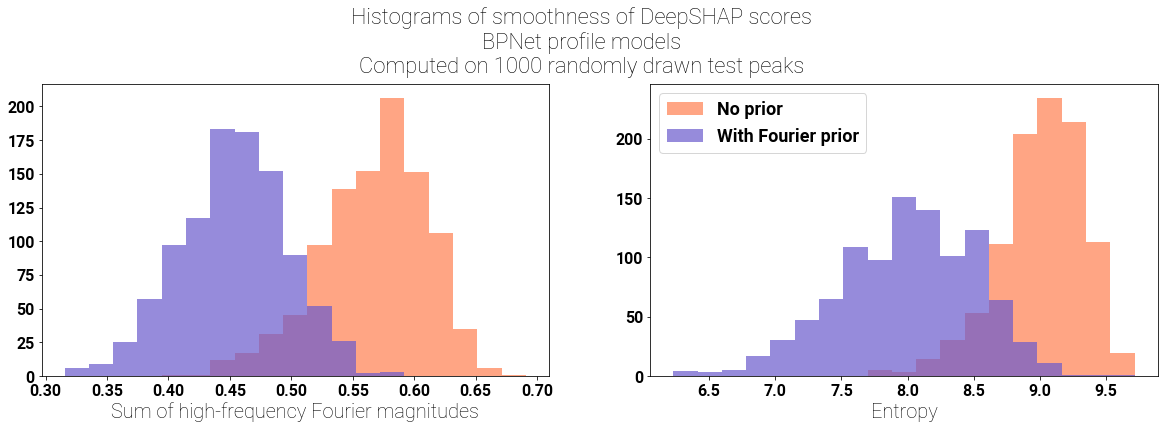

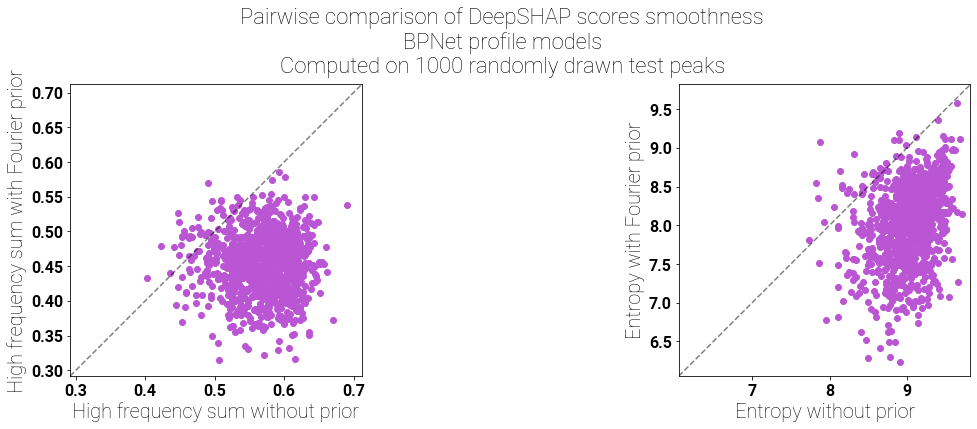

High-frequency Fourier sum:
Average without priors: 0.567267
Average with priors: 0.453142
One-sided Wilcoxon test: w = 497556.000000, p = 0.000000
Entropy:
Average without priors: 9.013379
Average with priors: 8.003641
One-sided Wilcoxon test: w = 498343.000000, p = 0.000000


In [26]:
plot_global_smoothness(
    noprior_shap_fourier_scores, prior_shap_fourier_scores, noprior_shap_entropy_scores,
    prior_shap_entropy_scores, "DeepSHAP scores"
)

### Plotting functions

In [27]:
def plot_profiles(pred_profs, true_profs, title=None):
    """
    Plots the given profiles.
    Both arguments should be T x O x S NumPy arrays, where the subarrays are the
    tracks for the plus and minus strand (or unstranded), for each task.
    If `normalize` is True, normalize the profiles to be probabilities (i.e.
    each track sums to 1)
    """
    num_tasks, prof_length, num_strands = pred_profs.shape
    fig, ax = plt.subplots(num_tasks, figsize=(15, num_tasks * 2 * num_strands))
    if num_tasks == 1:
        ax = [ax]
    for i in range(num_tasks):
        ax[i].plot(true_profs[i,:,0], color="royalblue", alpha=0.5)
        ax[i].plot(pred_profs[i,:,0], color="darkslateblue")
        if num_strands == 2:
            ax[i].plot(-true_profs[i,:,1], color="goldenrod", alpha=0.5)
            ax[i].plot(-pred_profs[i,:,1], color="darkorange")
    if title:
        fig.suptitle(title)
    plt.show()

In [28]:
def plot_fft(signal, include_dc=False, pos_limit=None, title=None):
    abs_signal = np.abs(signal)
    
    freqs, mags = dft(abs_signal)
    if not include_dc:
        freqs, mags = freqs[1:], mags[1:]
        
    plt.figure(figsize=(20, 2))
    plt.plot(freqs, mags, color="red")
    plt.xlabel("Frequency (radians)")
    plt.ylabel("|Frequency component|")
    if pos_limit is not None:
        pos_limit_radians = pos_limit * 2 * np.pi / len(signal)
        plt.axvline(x=pos_limit_radians, color="black")
    if title:
        plt.title(title)
    plt.show()

In [29]:
def plot_signal(signal, title=None, color=None):
    plt.figure(figsize=(20, 2))
    plt.plot(signal, color=color)
    if title:
        plt.title(title)
    plt.show()

### View predictions

In [30]:
def predict_and_plot(
    model, shap_explainer, chrom, start, end, with_priors, show_sequences=True,
    seq_slices=[slice(650, 750)]
):
    if type(seq_slices) is not list:
        seq_slices = [seq_slices]
    results = compute_predictions.get_profile_model_predictions(                                              
        model, [(chrom, start, end)] * 50, num_tasks, input_func, controls=controls,                        
        return_losses=False, return_gradients=True, show_progress=False                                         
    )
    true_profs = results["true_profs"]
    log_pred_profs = results["log_pred_profs"]
    input_seqs = results["input_seqs"]
    input_grads = results["input_grads"]

    pred_prof_probs = np.exp(log_pred_profs)
    true_prof_probs = true_profs / np.sum(true_profs, axis=2, keepdims=True)
    
    # plot_profiles(pred_prof_probs[0], true_prof_probs[0])
    
    color = "slateblue" if with_priors else "coral"
    print("Input gradients and Fourier transform")
    plot_signal(np.sum(input_grads[0] * input_seqs[0], axis=1), title="Input gradients", color=color)
    plot_fft(np.sum(input_grads[0] * input_seqs[0], axis=1), pos_limit=200, title="Fourier transform of input gradients")
    if show_sequences:
        for seq_slice in seq_slices:
            viz_sequence.plot_weights(input_grads[0][seq_slice], subticks_frequency=1000)
            viz_sequence.plot_weights((input_grads[0] * input_seqs[0])[seq_slice], subticks_frequency=1000)
    
    print("DeepSHAP scores")
    input_seqs, profiles = input_func([(chrom, start, end)] * 5)
    hyp_shap_scores = shap_explainer(
        input_seqs, cont_profs=profiles[:, num_tasks:], hide_shap_output=True
    )
    plot_signal(np.sum(hyp_shap_scores[0] * input_seqs[0], axis=1), title="DeepSHAP scores", color=color)
    if show_sequences:
        for seq_slice in seq_slices:
            viz_sequence.plot_weights(hyp_shap_scores[0][seq_slice], subticks_frequency=1000)
            viz_sequence.plot_weights((hyp_shap_scores[0] * input_seqs[0])[seq_slice], subticks_frequency=1000)
    
    print("ISM scores")
    hyp_ism_scores = compute_ism.get_profile_model_ism(
        model, input_seqs, cont_profs=profiles[:, num_tasks:], task_index=task_index
    )
    plot_signal(np.sum(hyp_ism_scores[0] * input_seqs[0], axis=1), title="ISM scores", color=color)
    if show_sequences:
        for seq_slice in seq_slices:
            viz_sequence.plot_weights(hyp_ism_scores[0][seq_slice], subticks_frequency=1000)
            viz_sequence.plot_weights((hyp_ism_scores[0] * input_seqs[0])[seq_slice], subticks_frequency=1000)

In [31]:
# Sample some random peaks
pos_coords[np.random.choice(len(pos_coords), size=10, replace=False)]

array([['chr1', 89713938, 89714282],
       ['chr1', 152655019, 152655218],
       ['chr1', 190805896, 190806054],
       ['chr1', 105013502, 105013593],
       ['chr1', 118228517, 118228861],
       ['chr1', 12354448, 12354792],
       ['chr1', 38969620, 38969825],
       ['chr1', 84637230, 84637574],
       ['chr1', 39460451, 39460795],
       ['chr1', 36994385, 36994729]], dtype=object)

In [32]:
# The coordinates that show the most improvement in prior loss
sample_coords[np.flip(np.argsort(noprior_preds["att_losses"] - prior_preds["att_losses"]))][:10]

array([['chr1', 135180758, 135181102],
       ['chr1', 97769817, 97770161],
       ['chr1', 172413956, 172414300],
       ['chr1', 63200179, 63200479],
       ['chr1', 156938809, 156939109],
       ['chr1', 9238992, 9239336],
       ['chr1', 155056489, 155056634],
       ['chr1', 84333192, 84333390],
       ['chr1', 17434091, 17434435],
       ['chr1', 134860737, 134861001]], dtype=object)

In [ ]:
# SPI1
chrom, start, end = 'chr1', 35434438, 35434678
seq_slices = [slice(200, 500), slice(525, 575)]
show_sequences = True
predict_and_plot(noprior_model, noprior_shap_explainer, chrom, start, end, False, show_sequences, seq_slices)
predict_and_plot(prior_model, prior_shap_explainer, chrom, start, end, True, show_sequences, seq_slices)

In [ ]:
# SPI1 (bQTL)
chrom, start, end = 'chr1', 220718074 - (1346 // 2), 220718074 + (1346 // 2)
seq_slices = [slice(663, 683)]
show_sequences = True
predict_and_plot(noprior_model, noprior_shap_explainer, chrom, start, end, False, show_sequences, seq_slices)
predict_and_plot(prior_model, prior_shap_explainer, chrom, start, end, True, show_sequences, seq_slices)

In [ ]:
# GATA2
chrom, start, end = 'chr1', 155117668, 155118072
seq_slices = [slice(625, 675)]
show_sequences = True
predict_and_plot(noprior_model, noprior_shap_explainer, chrom, start, end, False, show_sequences, seq_slices)
predict_and_plot(prior_model, prior_shap_explainer, chrom, start, end, True, show_sequences, seq_slices)

In [ ]:
# K562
chrom, start, end = 'chr1', 153404765, 153405084
seq_slices = [slice(575, 700)]
show_sequences = True
predict_and_plot(noprior_model, noprior_shap_explainer, chrom, start, end, False, show_sequences, seq_slices)
predict_and_plot(prior_model, prior_shap_explainer, chrom, start, end, True, show_sequences, seq_slices)

In [ ]:
# BPNet (Nanog)
chrom, start, end = 'chr1', 157459024, 157459288
seq_slices = [slice(625, 700)]
show_sequences = True
predict_and_plot(noprior_model, noprior_shap_explainer, chrom, start, end, False, show_sequences, seq_slices)
predict_and_plot(prior_model, prior_shap_explainer, chrom, start, end, True, show_sequences, seq_slices)

In [ ]:
# BPNet (Nanog)
chrom, start, end = 'chr1', 186386397, 186386741
seq_slices = [slice(625, 725)]
show_sequences = True
predict_and_plot(noprior_model, noprior_shap_explainer, chrom, start, end, False, show_sequences, seq_slices)
predict_and_plot(prior_model, prior_shap_explainer, chrom, start, end, True, show_sequences, seq_slices)

In [ ]:
# BPNet (Oct4)
chrom, start, end = 'chr1', 192763472, 192763816
seq_slices = [slice(400, 450)]
show_sequences = True
predict_and_plot(noprior_model, noprior_shap_explainer, chrom, start, end, False, show_sequences, seq_slices)
predict_and_plot(prior_model, prior_shap_explainer, chrom, start, end, True, show_sequences, seq_slices)

In [ ]:
# BPNet (Oct4)
chrom, start, end = 'chr1', 171150446, 171150446
seq_slices = [slice(525, 575), slice(900, 1200)]
show_sequences = True
predict_and_plot(noprior_model, noprior_shap_explainer, chrom, start, end, False, show_sequences, seq_slices)
predict_and_plot(prior_model, prior_shap_explainer, chrom, start, end, True, show_sequences, seq_slices)